In [12]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from skyfield.api import load
from matplotlib.patheffects import withStroke
import numpy as np

# 고급 지도 설정
def add_advanced_map_features(ax):
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='gray', linewidth=0.5)
    ax.add_feature(cfeature.LAKES, facecolor='blue', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.RIVERS, edgecolor='blue', linewidth=0.5)

# TLE 데이터 로드
stations_url = 'https://celestrak.com/NORAD/elements/stations.txt'
satellites = load.tle_file(stations_url)
satellite = {sat.name: sat for sat in satellites}['ISS (ZARYA)']

# 시간 스케일 로드
ts = load.timescale()

# 지도 설정
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(16, 9))
ax.set_facecolor('white')  # 밝은 배경
ax.set_title('Real-Time ISS Tracker - Enhanced Visuals', fontsize=20, fontweight='bold', color='black', pad=20)

# 지도에 고급 정보 추가
add_advanced_map_features(ax)

# 지도에 경도와 위도 포맷 설정
ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')

# 데이터 초기화
current_marker, = ax.plot([], [], marker='o', color='red', markersize=10, label='ISS Current Location')
orbit_line, = ax.plot([], [], color='darkgreen', linewidth=2, linestyle='-', alpha=0.8, label='Predicted Orbit Path')
current_text = ax.text(0, 0, '', transform=ccrs.PlateCarree(), fontsize=12, color='black', weight='bold')

# 궤적 계산 함수
def compute_predicted_orbit(satellite, ts, steps=120, interval=30):
    latitudes = []
    longitudes = []
    current_time = ts.now()
    for step in range(steps):
        future_time = current_time + step * interval / (24 * 3600)
        geocentric = satellite.at(future_time)
        subpoint = geocentric.subpoint()
        latitudes.append(subpoint.latitude.degrees)
        longitudes.append(subpoint.longitude.degrees)
    return longitudes, latitudes

# 애니메이션 업데이트 함수
def update(frame):
    # 현재 시간 기준 위성 위치 계산
    t = ts.now()
    geocentric = satellite.at(t)
    subpoint = geocentric.subpoint()

    latitude = subpoint.latitude.degrees
    longitude = subpoint.longitude.degrees

    # 현재 위치 업데이트
    current_marker.set_data([longitude], [latitude])
    current_text.set_position((longitude + 3, latitude + 3))
    current_text.set_text(f"ISS\nLat: {latitude:.2f}°\nLon: {longitude:.2f}°")
    current_text.set_path_effects([withStroke(linewidth=3, foreground="white")])  # 텍스트 외곽선 추가

    # 궤적 업데이트
    pred_longitudes, pred_latitudes = compute_predicted_orbit(satellite, ts)
    orbit_line.set_data(pred_longitudes, pred_latitudes)

    return current_marker, orbit_line, current_text

# 애니메이션 실행
ani = FuncAnimation(
    fig,
    update,
    interval=500,
    blit=True,
    save_count=200
)

# 범례 설정
ax.legend(
    loc='lower left',
    fontsize=14,
    facecolor='white',
    edgecolor='black'
)

# 표시
plt.show()


In [16]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.io import shapereader
from skyfield.api import load
from matplotlib.patheffects import withStroke
import numpy as np

# 흑백 지도 설정
def add_black_map_features(ax):
    land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='white', facecolor='gray')
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                         edgecolor='white', facecolor='black')
    lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                         edgecolor='white', facecolor='black')
    rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m',
                                          edgecolor='white', facecolor='none')
    ax.add_feature(land, zorder=0)
    ax.add_feature(ocean, zorder=0)
    ax.add_feature(lakes, zorder=1)
    ax.add_feature(rivers, linewidth=0.5, zorder=2)
    ax.coastlines(color='white', linewidth=0.8)

    # 주요 도시 표시
    cities_shp = shapereader.natural_earth(category='cultural', name='populated_places')
    for city in shapereader.Reader(cities_shp).records():
        city_name = city.attributes['NAME']  # 도시 이름
        longitude, latitude = city.geometry.x, city.geometry.y
        if city.attributes['POP_MAX'] > 1000000:  # 인구 100만 이상 도시만 표시
            ax.plot(longitude, latitude, marker='o', color='white', markersize=4, transform=ccrs.PlateCarree())
            ax.text(longitude + 2, latitude, city_name, fontsize=8, color='white', transform=ccrs.PlateCarree(),
                    path_effects=[withStroke(linewidth=1, foreground="black")])  # 외곽선 추가

# TLE 데이터 로드
stations_url = 'https://celestrak.com/NORAD/elements/stations.txt'
satellites = load.tle_file(stations_url)
satellite = {sat.name: sat for sat in satellites}['ISS (ZARYA)']

# 시간 스케일 로드
ts = load.timescale()

# 지도 설정
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(16, 9))
ax.set_facecolor('black')  # 검은 배경
ax.set_title('Real-Time ISS Tracker - Black Background Map', fontsize=18, fontweight='bold', color='white', pad=10)

# 지도에 흑백 스타일 추가
add_black_map_features(ax)

# 경도와 위도 포맷 설정
ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')

# 데이터 초기화
current_marker, = ax.plot([], [], marker='o', color='red', markersize=10, label='ISS Current Location')
orbit_line, = ax.plot([], [], color='white', linewidth=1.5, linestyle='-', alpha=0.8, label='Predicted Orbit Path')
current_text = ax.text(0, 0, '', transform=ccrs.PlateCarree(), fontsize=12, color='white', weight='bold')

# 궤적 계산 함수
def compute_predicted_orbit(satellite, ts, steps=120, interval=30):
    latitudes = []
    longitudes = []
    current_time = ts.now()
    for step in range(steps):
        future_time = current_time + step * interval / (24 * 3600)
        geocentric = satellite.at(future_time)
        subpoint = geocentric.subpoint()
        latitudes.append(subpoint.latitude.degrees)
        longitudes.append(subpoint.longitude.degrees)
    return longitudes, latitudes

# 애니메이션 업데이트 함수
def update(frame):
    # 현재 시간 기준 위성 위치 계산
    t = ts.now()
    geocentric = satellite.at(t)
    subpoint = geocentric.subpoint()

    latitude = subpoint.latitude.degrees
    longitude = subpoint.longitude.degrees

    # 현재 위치 업데이트
    current_marker.set_data([longitude], [latitude])
    current_text.set_position((longitude + 5, latitude + 5))
    current_text.set_text(f"ISS\nLat: {latitude:.2f}°\nLon: {longitude:.2f}°")
    current_text.set_path_effects([withStroke(linewidth=3, foreground="black")])  # 텍스트 외곽선 추가

    # 궤적 업데이트
    pred_longitudes, pred_latitudes = compute_predicted_orbit(satellite, ts)
    orbit_line.set_data(pred_longitudes, pred_latitudes)

    return current_marker, orbit_line, current_text

# 애니메이션 실행
ani = FuncAnimation(
    fig,
    update,
    interval=500,
    blit=True,
    save_count=200
)

# 범례 설정
legend = ax.legend(
    loc='lower left',
    fontsize=12,
    facecolor='black',
    edgecolor='white',
    framealpha=0.9  # 반투명 범례
)
for text in legend.get_texts():
    text.set_color('white')  # 범례 글씨 흰색으로 변경

# 여백 제거
plt.tight_layout()

# 표시
plt.show()


In [19]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from skyfield.api import load
from matplotlib.patheffects import withStroke
import numpy as np

# 흑백 지도 설정
def add_black_map_features(ax):
    land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='white', facecolor='gray')
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                         edgecolor='white', facecolor='black')
    lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                         edgecolor='white', facecolor='black')
    rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m',
                                          edgecolor='white', facecolor='none')
    ax.add_feature(land, zorder=0)
    ax.add_feature(ocean, zorder=0)
    ax.add_feature(lakes, zorder=1)
    ax.add_feature(rivers, linewidth=0.5, zorder=2)
    ax.coastlines(color='white', linewidth=0.8)

    # 주요 도시 표시
    cities_shp = shapereader.natural_earth(category='cultural', name='populated_places')
    for city in shapereader.Reader(cities_shp).records():
        city_name = city.attributes['NAME']  # 도시 이름
        longitude, latitude = city.geometry.x, city.geometry.y
        if city.attributes['POP_MAX'] > 1000000:  # 인구 100만 이상 도시만 표시
            ax.plot(longitude, latitude, marker='o', color='white', markersize=4, transform=ccrs.PlateCarree())
            ax.text(longitude + 2, latitude, city_name, fontsize=8, color='white', transform=ccrs.PlateCarree(),
                    path_effects=[withStroke(linewidth=1, foreground="black")])  # 외곽선 추가

# TLE 데이터 로드
stations_url = 'https://celestrak.com/NORAD/elements/stations.txt'
satellites = load.tle_file(stations_url)
satellite = {sat.name: sat for sat in satellites}['ISS (ZARYA)']

# 시간 스케일 로드
ts = load.timescale()

# 지도 설정
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(16, 9))
ax.set_facecolor('black')  # 검은 배경

# 지도에 흑백 스타일 추가
add_black_map_features(ax)

# 모든 축과 틱 마커 제거
ax.axis('off')

# 데이터 초기화
current_marker, = ax.plot([], [], marker='o', color='red', markersize=10, label='ISS Current Location')
orbit_line, = ax.plot([], [], color='white', linewidth=1.5, linestyle='-', alpha=0.8, label='Predicted Orbit Path')
current_text = ax.text(0, 0, '', transform=ccrs.PlateCarree(), fontsize=12, color='white', weight='bold')

# 궤적 계산 함수
def compute_predicted_orbit(satellite, ts, steps=120, interval=30):
    latitudes = []
    longitudes = []
    current_time = ts.now()
    for step in range(steps):
        future_time = current_time + step * interval / (24 * 3600)
        geocentric = satellite.at(future_time)
        subpoint = geocentric.subpoint()
        latitudes.append(subpoint.latitude.degrees)
        longitudes.append(subpoint.longitude.degrees)
    return longitudes, latitudes

# 애니메이션 업데이트 함수
def update(frame):
    # 현재 시간 기준 위성 위치 계산
    t = ts.now()
    geocentric = satellite.at(t)
    subpoint = geocentric.subpoint()

    latitude = subpoint.latitude.degrees
    longitude = subpoint.longitude.degrees

    # 현재 위치 업데이트
    current_marker.set_data([longitude], [latitude])
    current_text.set_position((longitude + 5, latitude + 5))
    current_text.set_text(f"ISS\nLat: {latitude:.2f}°\nLon: {longitude:.2f}°")
    current_text.set_path_effects([withStroke(linewidth=3, foreground="black")])  # 텍스트 외곽선 추가

    # 궤적 업데이트
    pred_longitudes, pred_latitudes = compute_predicted_orbit(satellite, ts)
    orbit_line.set_data(pred_longitudes, pred_latitudes)

    return current_marker, orbit_line, current_text

# 애니메이션 실행
ani = FuncAnimation(
    fig,
    update,
    interval=500,
    blit=True,
    save_count=200
)

# 범례 설정
legend = ax.legend(
    loc='lower left',
    fontsize=12,
    facecolor='black',
    edgecolor='white',
    framealpha=0.9  # 반투명 범례
)
for text in legend.get_texts():
    text.set_color('white')  # 범례 글씨 흰색으로 변경

# 여백 제거
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# 표시
plt.show()


C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_49400\3421218613.py:78: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=500, blit=True)


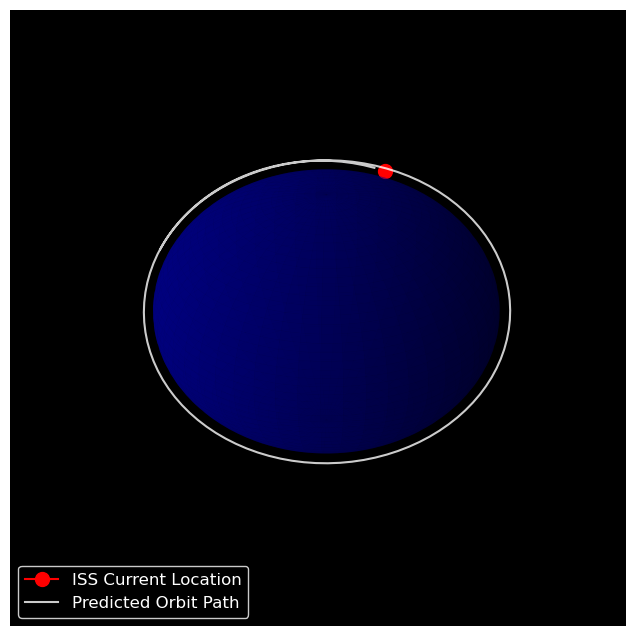

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from skyfield.api import load
import numpy as np

# TLE 데이터 로드
stations_url = 'https://celestrak.com/NORAD/elements/stations.txt'
satellites = load.tle_file(stations_url)
satellite = {sat.name: sat for sat in satellites}['ISS (ZARYA)']

# 시간 스케일 로드
ts = load.timescale()

# 지구 그리드 생성
def create_earth(ax):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = 6371 * np.outer(np.cos(u), np.sin(v))
    y = 6371 * np.outer(np.sin(u), np.sin(v))
    z = 6371 * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color='blue', alpha=0.3, edgecolor='none')

# 위성 위치 계산 함수
def compute_satellite_position(satellite, ts, time):
    geocentric = satellite.at(time)
    subpoint = geocentric.subpoint()
    latitude = np.radians(subpoint.latitude.degrees)
    longitude = np.radians(subpoint.longitude.degrees)
    altitude = 6371 + subpoint.elevation.km  # 지구 반지름 포함
    x = altitude * np.cos(latitude) * np.cos(longitude)
    y = altitude * np.cos(latitude) * np.sin(longitude)
    z = altitude * np.sin(latitude)
    return x, y, z

# 애니메이션 업데이트 함수
def update(frame):
    t = ts.now()
    x, y, z = compute_satellite_position(satellite, ts, t)

    # 현재 위치 업데이트
    sat_marker.set_data([x], [y])
    sat_marker.set_3d_properties([z])

    # 궤적 업데이트
    longitudes, latitudes, altitudes = [], [], []
    for step in range(1, 121):  # 궤적 계산 (2시간치)
        future_time = t + step * 60 / (24 * 3600)  # 60초 간격
        fx, fy, fz = compute_satellite_position(satellite, ts, future_time)
        longitudes.append(fx)
        latitudes.append(fy)
        altitudes.append(fz)
    orbit_line.set_data(longitudes, latitudes)
    orbit_line.set_3d_properties(altitudes)

    return sat_marker, orbit_line

# 3D 플롯 설정
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('black')
ax.grid(False)
ax.axis('off')

# 축 설정
ax.set_xlim([-7000, 7000])
ax.set_ylim([-7000, 7000])
ax.set_zlim([-7000, 7000])

# 지구 생성
create_earth(ax)

# 위성 초기 위치
sat_marker, = ax.plot([], [], [], marker='o', color='red', markersize=10, label='ISS Current Location')
orbit_line, = ax.plot([], [], [], color='white', linewidth=1.5, linestyle='-', alpha=0.8, label='Predicted Orbit Path')

# 애니메이션 실행
ani = FuncAnimation(fig, update, interval=500, blit=True)

# 범례 설정
legend = ax.legend(loc='lower left', fontsize=12, facecolor='black', edgecolor='white')
for text in legend.get_texts():
    text.set_color('white')

plt.show()


C:\Users\Choe JongHyeon\AppData\Local\Temp\ipykernel_49400\3537042100.py:95: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=500, blit=True)


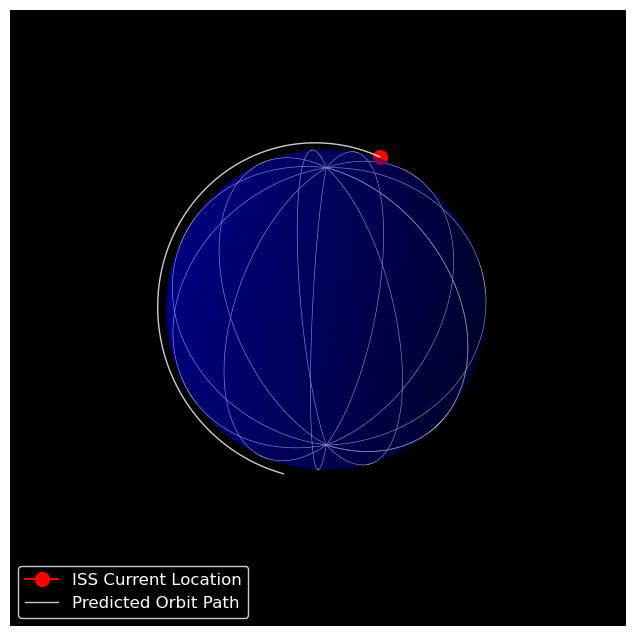

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from skyfield.api import load
import numpy as np

# TLE 데이터 로드
stations_url = 'https://celestrak.com/NORAD/elements/stations.txt'
satellites = load.tle_file(stations_url)
satellite = {sat.name: sat for sat in satellites}['ISS (ZARYA)']

# 시간 스케일 로드
ts = load.timescale()

# 지구 그리드 생성 (위도/경도 라인 추가)
def create_earth_with_grid(ax):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = 6371 * np.outer(np.cos(u), np.sin(v))
    y = 6371 * np.outer(np.sin(u), np.sin(v))
    z = 6371 * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color='blue', alpha=0.3, edgecolor='none')

    # 위도/경도 라인 추가
    for angle in np.linspace(0, 2 * np.pi, 12):
        x_line = 6371 * np.cos(angle) * np.sin(v)
        y_line = 6371 * np.sin(angle) * np.sin(v)
        z_line = 6371 * np.cos(v)
        ax.plot(x_line, y_line, z_line, color="white", linewidth=0.5)

    for angle in np.linspace(0, np.pi, 6):
        x_line = 6371 * np.outer(np.cos(u), np.sin(angle))
        y_line = 6371 * np.outer(np.sin(u), np.sin(angle))
        z_line = 6371 * np.outer(np.ones(np.size(u)), np.cos(angle))
        ax.plot(x_line[0], y_line[0], z_line[0], color="white", linewidth=0.5)

# 위성 위치 계산 함수
def compute_satellite_positions(satellite, ts, start_time, steps, interval_sec):
    positions = []
    for step in range(steps):
        future_time = start_time + step * interval_sec / (24 * 3600)  # 초 단위로 계산
        x, y, z = compute_satellite_position(satellite, ts, future_time)
        positions.append((x, y, z))
    return np.array(positions)

def compute_satellite_position(satellite, ts, time):
    geocentric = satellite.at(time)
    subpoint = geocentric.subpoint()
    latitude = np.radians(subpoint.latitude.degrees)
    longitude = np.radians(subpoint.longitude.degrees)
    altitude = 6371 + subpoint.elevation.km  # 지구 반지름 포함
    x = altitude * np.cos(latitude) * np.cos(longitude)
    y = altitude * np.cos(latitude) * np.sin(longitude)
    z = altitude * np.sin(latitude)
    return x, y, z

# 애니메이션 업데이트 함수
def update(frame):
    t = ts.now()
    x, y, z = compute_satellite_position(satellite, ts, t)

    # 현재 위치 업데이트
    sat_marker.set_data([x], [y])
    sat_marker.set_3d_properties([z])

    # 궤적 업데이트
    positions = compute_satellite_positions(satellite, ts, t, steps=300, interval_sec=10)  # 더 많은 샘플링
    orbit_line.set_data(positions[:, 0], positions[:, 1])
    orbit_line.set_3d_properties(positions[:, 2])

    return sat_marker, orbit_line

# 3D 플롯 설정
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('black')
ax.grid(False)
ax.axis('off')

# 축 설정
max_range = 7000
ax.set_xlim([-max_range, max_range])
ax.set_ylim([-max_range, max_range])
ax.set_zlim([-max_range, max_range])
ax.set_box_aspect([1, 1, 1])

# 지구 생성
create_earth_with_grid(ax)

# 위성 초기 위치
sat_marker, = ax.plot([], [], [], marker='o', color='red', markersize=10, label='ISS Current Location')
orbit_line, = ax.plot([], [], [], color='white', linewidth=1, linestyle='-', alpha=0.8, label='Predicted Orbit Path')

# 애니메이션 실행
ani = FuncAnimation(fig, update, interval=500, blit=True)

# 범례 설정
legend = ax.legend(loc='lower left', fontsize=12, facecolor='black', edgecolor='white')
for text in legend.get_texts():
    text.set_color('white')

plt.show()


In [2]:
import matplotlib
matplotlib.use('TkAgg')  # 또는 'Qt5Agg'

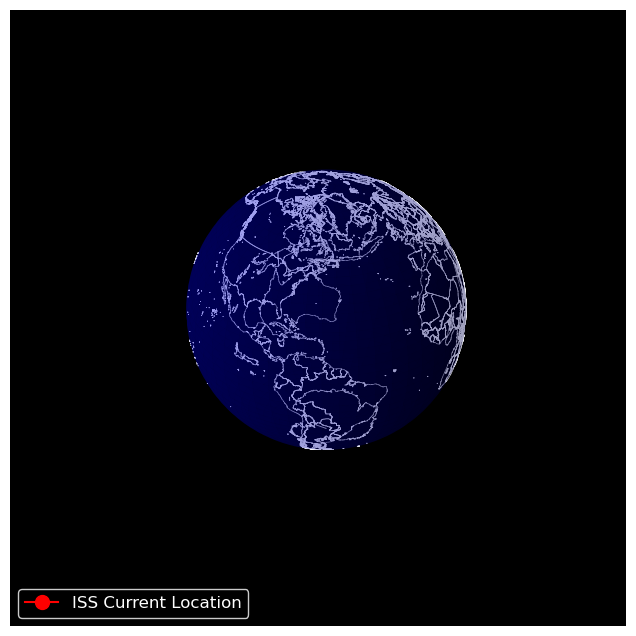

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.animation import FuncAnimation
from skyfield.api import load
import numpy as np
import cartopy.feature as cfeature
from shapely.geometry import MultiPolygon, Polygon

# TLE 데이터 로드
stations_url = 'https://celestrak.com/NORAD/elements/stations.txt'
satellites = load.tle_file(stations_url)
satellite = {sat.name: sat for sat in satellites}['ISS (ZARYA)']

# 시간 스케일 로드
ts = load.timescale()

# 미리 계산된 위성 궤적 데이터 저장
def compute_satellite_positions(satellite, ts, start_time, steps, interval_sec):
    positions = []
    for step in range(steps):
        future_time = start_time + step * interval_sec / (24 * 3600)  # 초 단위로 계산
        x, y, z = compute_satellite_position(satellite, ts, future_time)
        positions.append((x, y, z))
    return np.array(positions)

def compute_satellite_position(satellite, ts, time):
    geocentric = satellite.at(time)
    subpoint = geocentric.subpoint()
    latitude = np.radians(subpoint.latitude.degrees)
    longitude = np.radians(subpoint.longitude.degrees)
    altitude = 6371 + subpoint.elevation.km  # 지구 반지름 포함
    x = altitude * np.cos(latitude) * np.cos(longitude)
    y = altitude * np.cos(latitude) * np.sin(longitude)
    z = altitude * np.sin(latitude)
    return x, y, z

# 궤적 미리 계산하기 (위성 궤적을 미리 계산해서 저장)
start_time = ts.now()
steps = 1000  # 계산할 궤적 점 수
interval_sec = 10  # 시간 간격 (초)
positions = compute_satellite_positions(satellite, ts, start_time, steps, interval_sec)

# 지구와 국가 경계선 생성
def create_earth_with_countries(ax, earth_radius=6371):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = earth_radius * np.outer(np.cos(u), np.sin(v))
    y = earth_radius * np.outer(np.sin(u), np.sin(v))
    z = earth_radius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color='blue', alpha=0.2, edgecolor='none')

    # 경계선 추가
    for feature in cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m').geometries():
        if isinstance(feature, Polygon):  # 단일 Polygon 처리
            coords = list(feature.exterior.coords)
            plot_country_boundary(ax, coords, earth_radius)
        elif isinstance(feature, MultiPolygon):  # MultiPolygon 처리
            for polygon in feature.geoms:
                coords = list(polygon.exterior.coords)
                plot_country_boundary(ax, coords, earth_radius)

def plot_country_boundary(ax, coords, earth_radius):
    for i in range(len(coords) - 1):
        lon1, lat1 = coords[i]
        lon2, lat2 = coords[i + 1]
        x1 = earth_radius * np.cos(np.radians(lat1)) * np.cos(np.radians(lon1))
        y1 = earth_radius * np.cos(np.radians(lat1)) * np.sin(np.radians(lon1))
        z1 = earth_radius * np.sin(np.radians(lat1))

        x2 = earth_radius * np.cos(np.radians(lat2)) * np.cos(np.radians(lon2))
        y2 = earth_radius * np.cos(np.radians(lat2)) * np.sin(np.radians(lon2))
        z2 = earth_radius * np.sin(np.radians(lat2))

        ax.plot([x1, x2], [y1, y2], [z1, z2], color='white', linewidth=0.5, alpha=0.5)

# 애니메이션 업데이트 함수
def update(frame):
    x, y, z = positions[frame]

    # 현재 위치 업데이트
    sat_marker.set_data([x], [y])
    sat_marker.set_3d_properties([z])

    # 궤적 업데이트
    segments = [[positions[i], positions[i + 1]] for i in range(len(positions) - 1)]
    lc.set_segments(segments)

    return sat_marker, lc

# 3D 플롯 설정
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('black')
ax.grid(False)
ax.axis('off')

# 축 설정
max_range = 8000  # 궤적과 지구를 모두 포함하는 범위로 설정
ax.set_xlim([-max_range, max_range])
ax.set_ylim([-max_range, max_range])
ax.set_zlim([-max_range, max_range])
ax.set_box_aspect([1, 1, 1])

# 지구와 국가 경계선 생성
create_earth_with_countries(ax, earth_radius=6371)

# 위성 초기 위치
sat_marker, = ax.plot([], [], [], marker='o', color='red', markersize=10, label='ISS Current Location')

# 궤적 라인 설정 (Line3DCollection)
lc = Line3DCollection([], cmap='cool', linewidth=1.5, alpha=0.8)
ax.add_collection(lc)

# 애니메이션 실행 (미리 계산된 궤적 데이터 사용)
ani = FuncAnimation(fig, update, frames=range(len(positions)), interval=500, blit=False)

# 범례 설정
legend = ax.legend(loc='lower left', fontsize=12, facecolor='black', edgecolor='white')
for text in legend.get_texts():
    text.set_color('white')

# 애니메이션 출력
plt.show()


In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.animation import FuncAnimation
from skyfield.api import load
import numpy as np
import matplotlib
matplotlib.use('TkAgg')  # 또는 'Qt5Agg'

# TLE 데이터 로드
stations_url = 'https://celestrak.com/NORAD/elements/stations.txt'
satellites = load.tle_file(stations_url)
satellite = {sat.name: sat for sat in satellites}['ISS (ZARYA)']

# 시간 스케일 로드
ts = load.timescale()

# 미리 계산된 위성 궤적 데이터 저장
def compute_satellite_positions(satellite, ts, start_time, steps, interval_sec):
    positions = []
    for step in range(steps):
        future_time = start_time + step * interval_sec / (24 * 3600)  # 초 단위로 계산
        x, y, z = compute_satellite_position(satellite, ts, future_time)
        positions.append((x, y, z))  # z값 포함
    return np.array(positions)

def compute_satellite_position(satellite, ts, time):
    geocentric = satellite.at(time)
    subpoint = geocentric.subpoint()
    latitude = np.radians(subpoint.latitude.degrees)
    longitude = np.radians(subpoint.longitude.degrees)
    altitude = 6371 + subpoint.elevation.km  # 지구 반지름 포함
    x = altitude * np.cos(latitude) * np.cos(longitude)
    y = altitude * np.cos(latitude) * np.sin(longitude)
    z = altitude * np.sin(latitude)
    return x, y, z

# 미리 계산된 궤적 데이터 사용
start_time = ts.now()
steps = 200  # 프레임 수를 줄여서 성능 개선
interval_sec = 30  # 시간 간격
positions = compute_satellite_positions(satellite, ts, start_time, steps, interval_sec)

# 간소화된 지구와 국가 경계선 생성
def create_earth_with_countries(ax, earth_radius=6371):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = earth_radius * np.outer(np.cos(u), np.sin(v))
    y = earth_radius * np.outer(np.sin(u), np.sin(v))
    z = earth_radius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color='blue', alpha=0.2, edgecolor='none')

    # 간단한 경계선 추가: 원의 경계선만 표시
    lon = np.linspace(-180, 180, 360)
    lat = np.linspace(-90, 90, 180)
    
    for i in range(0, len(lon), 45):  # 경도선 그리기
        x = earth_radius * np.cos(np.radians(lat)) * np.cos(np.radians(lon[i]))
        y = earth_radius * np.cos(np.radians(lat)) * np.sin(np.radians(lon[i]))
        z = earth_radius * np.sin(np.radians(lat))
        ax.plot(x, y, z, color='white', lw=0.5)

    # 위도선 추가 (반복해서 그릴 수 있음)
    for j in range(0, len(lat), 45):  # 위도선 그리기
        x = earth_radius * np.cos(np.radians(lat[j])) * np.cos(np.radians(lon))
        y = earth_radius * np.cos(np.radians(lat[j])) * np.sin(np.radians(lon))
        z = earth_radius * np.sin(np.radians(lat[j]))
        ax.plot(x, y, z, color='white', lw=0.5)

# 애니메이션 업데이트 함수
def update(frame):
    x, y, z = positions[frame]

    # 현재 위치 업데이트
    sat_marker.set_data([x], [y])
    sat_marker.set_3d_properties([z])  # z값을 3D로 설정

    # 궤적 업데이트
    segments = [[positions[i], positions[i + 1]] for i in range(len(positions) - 1)]
    lc.set_segments(segments)

    return sat_marker, lc

# 3D 플롯 설정
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('black')
ax.grid(False)
ax.axis('off')

# 축 설정
max_range = 8000  # 궤적과 지구를 모두 포함하는 범위로 설정
ax.set_xlim([-max_range, max_range])
ax.set_ylim([-max_range, max_range])
ax.set_zlim([-max_range, max_range])
ax.set_box_aspect([1, 1, 1])

# 지구와 국가 경계선 생성
create_earth_with_countries(ax, earth_radius=6371)

# 위성 초기 위치
sat_marker, = ax.plot([], [], [], marker='o', color='red', markersize=10, label='ISS Current Location')

# 궤적 라인 설정 (Line3DCollection)
lc = Line3DCollection([], cmap='cool', linewidth=1.5, alpha=0.8)
ax.add_collection(lc)

# 애니메이션 실행 (미리 계산된 궤적 데이터 사용)
ani = FuncAnimation(fig, update, frames=range(len(positions)), interval=500, blit=False)

# 범례 설정
legend = ax.legend(loc='upper left', fontsize=12, facecolor='black', edgecolor='white')
for text in legend.get_texts():
    text.set_color('white')

# 애니메이션 출력
plt.show()


c:\Conda\Lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
